## Virtual Environment for Individual-Based Modeling

### Advanced Project I

Created on March 31, 2019 by Ralph Florent <r.florent@jacobs-university.de>

#### Description
WIP...

prob:  3.396098455118872e-07
prob:  3.404637558003747e-07
prob:  5.818663570630324e-06
prob:  1.766697582289216e-07
prob:  7.052769032617486e-06
prob:  7.052769032617486e-06
prob:  3.396098455118872e-07
prob:  5.818663570630324e-06
prob:  3.396098455118872e-07
prob:  7.052769032617486e-06
prob:  5.818663570630324e-06
prob:  1.766697582289216e-07
prob:  7.052769032617486e-06
prob:  7.052769032617486e-06
prob:  3.396098455118872e-07
prob:  3.956926680449013e-07
prob:  7.052769032617486e-06
prob:  7.052769032617486e-06
prob:  5.818663570630324e-06
prob:  1.766697582289216e-07
prob:  3.404637558003747e-07
prob:  5.818663570630324e-06
prob:  3.396098455118872e-07
prob:  7.052769032617486e-06
prob:  3.404637558003747e-07
prob:  3.404637558003747e-07
prob:  5.818663570630324e-06
prob:  1.766697582289216e-07
prob:  7.052769032617486e-06
prob:  7.052769032617486e-06
prob:  5.818663570630324e-06
prob:  3.396098455118872e-07
prob:  5.818663570630324e-06
prob:  7.052769032617486e-06
prob:  7.05276

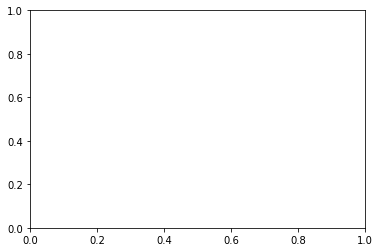

In [59]:
""" Individual-Based Modeling """

# -*- coding: utf-8 -*-
# 
# Created on March 31, 2019
# Authors: Ralph Florent <r.florent@jacobs-university.de>

### START: scripts

# Import relevant libraries
import numpy as np # arithmetic computations
import imageio as gm # gif maker
import matplotlib.pyplot as plt # plotter
import matplotlib.patches as Patches
from matplotlib.path import Path 

""" Global Default Variables """
# Path variables
MAIN_DIRECTORY = '../../dist/'
FILEPATH = MAIN_DIRECTORY + 'frame/'

# Miscellaneous variables
IMAGE_STORAGE = []  # images to become gif
PROCESSING_TIME = 50 # time limit for the entire process
t = 0 # initial time step over the overall processing time
THRESHOLD = 1e-7 # threshold to allow agents' movements driven by the probability

# Matplotlib Patches variables
HABITAT_1A_VERTICES = [
    (0.70, 0.51), # left, bottom
    (0.70, 0.86), # left, top
    (0.79, 0.86), # right, top
    (0.79, 0.51), # right, bottom
    (0.70, 0.51)  # ignored (end of polyline)
]
HABITAT_1B_VERTICES = [(0.20, 0.50), (0.20, 0.81), (0.42, 0.81), (0.42, 0.50), (0.20, 0.50)]
HABITAT_2_VERTICES  = [(0.10, 0.20), (0.10, 0.40), (0.40, 0.40), (0.40, 0.20), (0.10, 0.40)]
HABITAT_3_VERTICES  = [(0.60, 0.05), (0.60, 0.25), (0.70, 0.25), (0.70, 0.05), (0.60, 0.05)]
HUMAN_STM1_VERTICES = [(0.42, 0.67), (0.42, 0.86), (0.61, 0.86), (0.61, 0.67), (0.42, 0.67)]
HUMAN_STM2_VERTICES = [(0.85, 0.70), (0.85, 0.90), (0.95, 0.90), (0.95, 0.70), (0.85, 0.70)]
HUMAN_STM3_VERTICES = [(0.80, 0.15), (0.80, 0.25), (0.90, 0.25), (0.90, 0.15), (0.80, 0.15)]

# Total of Agents
TOTAL_LONG_LEGGED_SEABIRDS  = 20
TOTAL_SHORT_LEGGED_SEABIRDS = 20

# Seabird can use certain habitats
LONG_LEGGED_SEABIRD_HABITAT_LIMIT  = ['one', 'two', 'three']
SHORT_LEGGED_SEABIRD_HABITAT_LIMIT = ['one']

# The movement of the birds is driven by the probability
LONG_LEGGED_SEABIRD_HABITAT_PROB  = 0.1
SHORT_LEGGED_SEABIRD_HABITAT_PROB = 0.1


# Initial conditions
# Random so far


# Class definition for agent (seabirds)
class Agent:
    pass # On-the-fly properties

# Class definition for the habitats
class Habitat:
    def __init__(self, _type, verts, color='orange', props=None):
        self.type  = _type
        self.verts = verts
        self.color = color
        self.props = props
        
        self.codes = [
            Path.MOVETO, # start polycurve here
            Path.LINETO, # draw line to
            Path.LINETO, # draw line to 
            Path.LINETO, # draw line to
            Path.CLOSEPOLY,# finish polycurve here
        ]
        self.artist = None
        
    
    def build(self, color=None, fill=False):
        """ Create a set of patches within a specific area 
        ref: https://matplotlib.org/users/path_tutorial.html
        """
        c = color if color is not None else self.color
        path = Path(self.verts, self.codes)
        self.artist = Patches.PathPatch(path, ec=c, fc=c, fill=fill, alpha=0.5)
        return self.artist
    
    
    def contains_point(self, point):
        """ Check if a point belongs to this specific patch"""
        path = self.artist.get_path()
        return path.contains_point(point)
    
    
    def contains_points(self, points):
        """ Check if a set of points belongs to this specific patch"""
        path = self.artist.get_path()
        return path.contains_points(points)
    
    
    def count_points(self, points):
        counter = 0
        for point in points:
            if contains_point(self, point):
                counter += 1
        return counter
    
    def get_center(self):
        """ Compute the center point of the rectangle
        
        The center of rectangle is the mid point of the diagonal 
        end points of a rectangle ABCD.
        """
        A, B, C, D, _ = self.verts # ignore last vertex
        _x = (A[0] + D[0]) / 2 # width side
        _y = (A[1] + B[1]) / 2 # height side
        return (_x, _y)

    
def gen_rand_point(habitats, option=None):
    """ Generate random point that belongs (or not) to a set of patches 
    
    Parameters
    ----------
    patches: array of objects <matplotlib.patch>
        a set of patches (polycurve) to draw simple and compound outlines 
        consisting of line segments and splines.
        
    option: str = {'in', 'out', None}, default = None
            determine whether conditioning the random point being generated
            within or out of the patches. If not specified, return just 
            random points without considering the patches.
     
    Returns
    -------
    (x, y): tuple, of shape (x_coord, y_coord)
        a vertex of unit rectangle from (0,0) to (1,1).
    """
    # Make single element iterable
    habitats = habitats if isinstance(habitats, list) else [habitats]
    
    # initialize random point(x, y) by generating an array
    # of 2 random values between 0 and 1: [0.1..., 0.4...]
    x, y = np.random.rand(2)
    
    # flag up a condition to assess points within, or out of the patches
    if option == 'in':
        condition = lambda f: f
    elif option == 'out':
        condition = lambda f: not f
    else:
        return (x, y)
    
    # iterate until the point based on the given condition is found
    while True:
        found = False
        for habitat in habitats:
            if habitat.contains_point((x, y)):
                found = True
        
        # base condition to fulfill requirements
        if condition(found):
            break
        
        x, y = np.random.rand(2) # update point(x, y)
            
    return (x, y)


def compute_dist(habitat, human_settlements):
    """ Compute relative distances to the existing human settlements"""
    distances = []
    h_center = np.array( habitat.get_center() ) # center point of the habitat
    
    for settlement in human_settlements:
        s_center = np.array( settlement.get_center() )
        # compute distance between habitat and settlement 
        dist = np.linalg.norm(h_center - s_center)
        distances.append(dist)
        
    return distances # order of distances depends on settlements' settings


def which_habitat(point, habitats):
    """ Determine in which habitat dwells the current agent"""
    for h in habitats:
        if h.contains_point(point):
            return h
    return None


def create_patches():
    global habitats
    habitats = []
        
    # prepare static (patch-based) habitats and human settlements
    habitats.append( Habitat('one', HABITAT_1A_VERTICES, 'orange', {'w': 0.05, 's': 80}) )
    habitats.append( Habitat('one', HABITAT_1B_VERTICES, 'orange', {'w': 0.05, 's': 80}) )
    habitats.append( Habitat('two', HABITAT_2_VERTICES, 'blue', {'w': 1.0, 's': 10}) )
    habitats.append( Habitat('three', HABITAT_3_VERTICES, 'green', {'w': 0.40, 's': 25}) )
    habitats.append( Habitat('human', HUMAN_STM1_VERTICES, 'red') )
    habitats.append( Habitat('human', HUMAN_STM2_VERTICES, 'red') )
    habitats.append( Habitat('human', HUMAN_STM3_VERTICES, 'red') )
    
    # then build patch for each habitat
    for h in habitats:
        filled = False
        if h.type == 'human':
            filled = True
        h.build(fill=filled)
    
    return habitats


# create agents
def create_agents():
    global habitats, agents
    agents = []
    
    # build patches for short- and long-legged seabirds
    short_legged_habitat = [h for h in habitats if h.type in SHORT_LEGGED_SEABIRD_HABITAT_LIMIT]
    long_legged_habitat  = [h for h in habitats if h.type in LONG_LEGGED_SEABIRD_HABITAT_LIMIT]
    
    for i in range(TOTAL_SHORT_LEGGED_SEABIRDS + TOTAL_LONG_LEGGED_SEABIRDS):
        ag = Agent()
        
        # classify agents as short- and long-legged seabirds
        if i < TOTAL_SHORT_LEGGED_SEABIRDS:
            ag.type = 'short-legged'
            ag.x, ag.y = gen_rand_point(short_legged_habitat, 'in')
        else:
            ag.type = 'long-legged'
            ag.x, ag.y = gen_rand_point(long_legged_habitat, 'in')
            
        agents.append(ag) # store in-memory agents
    
    return agents


def initialize():
    create_patches()
    create_agents()

    
def observe():
    """ Create and plot figure """
    global habitats, agents
    plt.cla()
   
    fig = plt.figure(figsize=(11, 6.5)) # define figure size 11x6.5 inches
    ax  = fig.add_subplot(111)
    
    for h in habitats:
        ax.add_patch(h.artist) # add artists (patches) to display rectangles
    
    # distribute agents according their types
    short = [ag for ag in agents if ag.type == 'short-legged']
    long = [ag for ag in agents if ag.type == 'long-legged'] 

    # plot agents' positions
    ax.plot([ag.x for ag in short], [ag.y for ag in short], 'o', mfc ='k', mec ='k', label='short-legged')
    ax.plot([ag.x for ag in long], [ag.y for ag in long], 'o', mfc ='w', mec ='k', label='long-legged')
    
    # additional settings for the graph
    plt.axis('image')
    plt.axis([0, 1, 0, 1])
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(loc="best")
    plt.xlabel('Time ' + str(int(t)), fontsize=15) # Identify which image is plotted
    plt.title('Virtual Environment', fontsize=15) # Title the graph
    
    image_path = FILEPATH + str(int(t)) + '.png'
    plt.savefig(image_path, bbox_inches='tight', pad_inches=0)
    plt.close(fig)
    
    # storing image for final gif
    image = gm.imread(image_path)
    IMAGE_STORAGE.append(image)
    # END: observe


def update():
    global agents
    
    # Cannot put single artist in more than one figure
    habitats = create_patches()
    
    # build patches for short- and long-legged seabirds, human settlements
    short_legged_habitat = [h for h in habitats if h.type in SHORT_LEGGED_SEABIRD_HABITAT_LIMIT]
    long_legged_habitat  = [h for h in habitats if h.type in LONG_LEGGED_SEABIRD_HABITAT_LIMIT]
    human_settlements = [h for h in habitats if h.type == 'human']
    
    # randomly choose an agent to update its status, 
    # approach for asynchronous updates: see Davi's ref.
    agent = agents[ np.random.randint( len(agents) ) ]
    
    # simulating random movements
    """ Algorithm to move agents
    0: given a selected agent
    1: randomly choose a new destination (point)
    2: compute probability of habitat use for the destination
    3: move agent if doable (available, resourceful, unthreatening)
    
    Formulas to compute respective probabilities:
    
    P(large_wading_birds) = -0.0003 * w + 0.0087
    P(large_wading_birds) = -0.0004 * d + 0.0064
    P(large_wading_birds) = -0.000004 * (s^2) + 0.0004 * s - 0.0002
    
    P(small_wading_birds) = 0.00002 * (w^2) - 0.0009 * w + 0.0114 
    P(small_wading_birds) = -0.0013 * (d^2) + 0.0074 * d - 0.0001
    P(small_wading_birds) = 0.00006 * (s^2) + 0.0002 * s + 0.0004
    """
    
    if agent.type == 'short-legged':
        # [_variable_name] means variables within this scope
        _x, _y = gen_rand_point(short_legged_habitat, 'in')
        _habitat = which_habitat((_x, _y), short_legged_habitat)
        _d = compute_dist(_habitat, human_settlements)
        min_index = _d.index( min(_d) ) # consider minimal distance
        
        d = _d[min_index] # distance to human settlement
        w, s = _habitat.props.values() # water depth, salinity
        
        _prob_w = 0.00002 * w**2 - 0.0009 * w + 0.0114 
        _prob_d = -0.0013 * d**2 + 0.0074 * d - 0.0001
        _prob_s = 0.00006 * s**2 + 0.0002 * s + 0.0004
        prob = _prob_s * _prob_w * _prob_d
    else:
        _x, _y = gen_rand_point(long_legged_habitat, 'in')
        _habitat = which_habitat((_x, _y), long_legged_habitat)
        _d = compute_dist(_habitat, human_settlements)
        min_index = _d.index( min(_d) ) # consider minimal distance
        
        d = _d[min_index] # distance to human settlement
        w, s = _habitat.props.values() # water depth, salinity
        
        _prob_w = -0.0003 * w + 0.0087 
        _prob_d = -0.0004 * d + 0.0064
        _prob_s = -0.000004 * s**2 + 0.0004 * s - 0.0002
        prob = _prob_s * _prob_w * _prob_d
    
    if prob > THRESHOLD:
        agent.x, agent.y = _x, _y
    # END: update

    
plt.ioff() # turn off interactive plotting mode
# first time
initialize()
observe()

# loop over t-1 time
for t in range(1, PROCESSING_TIME):
    update()
    observe()

# create final gif
gm.mimsave(MAIN_DIRECTORY + 'image.gif', IMAGE_STORAGE)
### END: scripts